# Github: <font color=orange><a href='https://github.com/dimonko1'>@dimonko1</a></font>
# <font color=7E87FC>Heston Stochastic Volatility Model for Options</font>:
<hr>

### Модель разработали в 1993 г. – моделирование стохастической волатильности (стохвола).
### • Имеет closed-form solution для европейских опционов;
### • Нет риска отрицательной волатильности;
### • включение эффекта левериджа.
### Имеет ряд преимуществ перед моделью Блэка-Шоулза, т.к. в последней предполагается постоянная волатильность.
### <font color=7E87FC>Heston Model SDE</font>:
### В этих стохдиффурах и процесс цены актива, и процесс волатильности, подчиняются броуновскому движению при actual вероятностной мере $\mathbb{P}$.
### $dS_t = \mu S_tdt + \sqrt{v_t}S_tdW_{S,t}^{\mathbb{P}}$;
### $dv_t = k(\theta-v_t)dt+\sigma\sqrt{v_t}dW_{v,t}^{\mathbb{P}}$,
### где $\sigma$ – волатильность волатильности, $\theta$ – долгосрочная волатильность цены, $k$ – rate of reversion к долгосрочной волатильнсоти цены, $dW_{S,t}^{\mathbb{P}}$ – броуновское движение цены актива, $dW_{v,t}^{\mathbb{P}}$ – броуновское движение волатильности, $\rho^{\mathbb{P}}$ – корреляция между броуновскими движениями.
### <font color=7E87FC>Динамика при риск-нейтральной мере $\mathbb{Q}$</font>:
### $dS_t = rS_tdt+\sqrt{v_t}S_tdW_{S,t}^{\mathbb{Q}}$
### $dv_t = k^{\mathbb{Q}}(\theta^{\mathbb{Q}}-v_t)dt + \sigma^{\mathbb{Q}}\sqrt{v_t}dW_{v,t}^{\mathbb{Q}}$
### Дискретизация Euler and Milstein (может дать отрицательную волатильность, что bad), которую доработал Fabrice Douglas Rouah (https://frouah.com/finance%20notes/Euler%20and%20Milstein%20Discretization.pdf):
### $S_{i+1}=S_ie^{(r-\frac{v_i}{2})\Delta t+\sqrt{v_i}\Delta tW_{S,i+1}^{\mathbb{Q}}}$
### $v_{i+1} = v_i+k(\theta-v_t)\Delta t+ \sigma\sqrt{v_i}\Delta t W_{v,i+1}^{\mathbb{Q}}$

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from py_vollib_vectorized import vectorized_implied_volatility as implied_vol
import warnings
warnings.filterwarnings("ignore")

In [2]:
S0 = 100.0
T = 1.0
r = 0.02
N = 252
M = 500
kappa = 3
theta = 0.2**2
v0 = 0.25**2
rho = 0.7
sigma = 0.6

In [3]:
def heston_model_sim(S0, v0, rho, kappa, theta, sigma, T, N, M):
    dt = T/N
    mu = np.array([0,0])
    cov = np.array([[1,rho],
                  [rho,1]])

    S = np.full(shape=(N+1,M), fill_value=S0)
    v = np.full(shape=(N+1,M), fill_value=v0)
    Z = np.random.multivariate_normal(mu, cov, (N,M))
    
    for i in range(1, N+1):
        S[i] = S[i-1] * np.exp((r - 0.5*v[i-1])*dt + np.sqrt(v[i-1] * dt) * Z[i-1,:,0])
        v[i] = np.maximum(v[i-1] + kappa*(theta-v[i-1])*dt + sigma*np.sqrt(v[i-1]*dt)*Z[i-1,:,1],0)
    return S, v

In [4]:
rho_p = 0.98
rho_n = -0.98

S_p, v_p = heston_model_sim(S0, v0, rho_p, kappa, theta, sigma, T, N, M)
S_n, v_n = heston_model_sim(S0, v0, rho_n, kappa, theta, sigma, T, N, M)

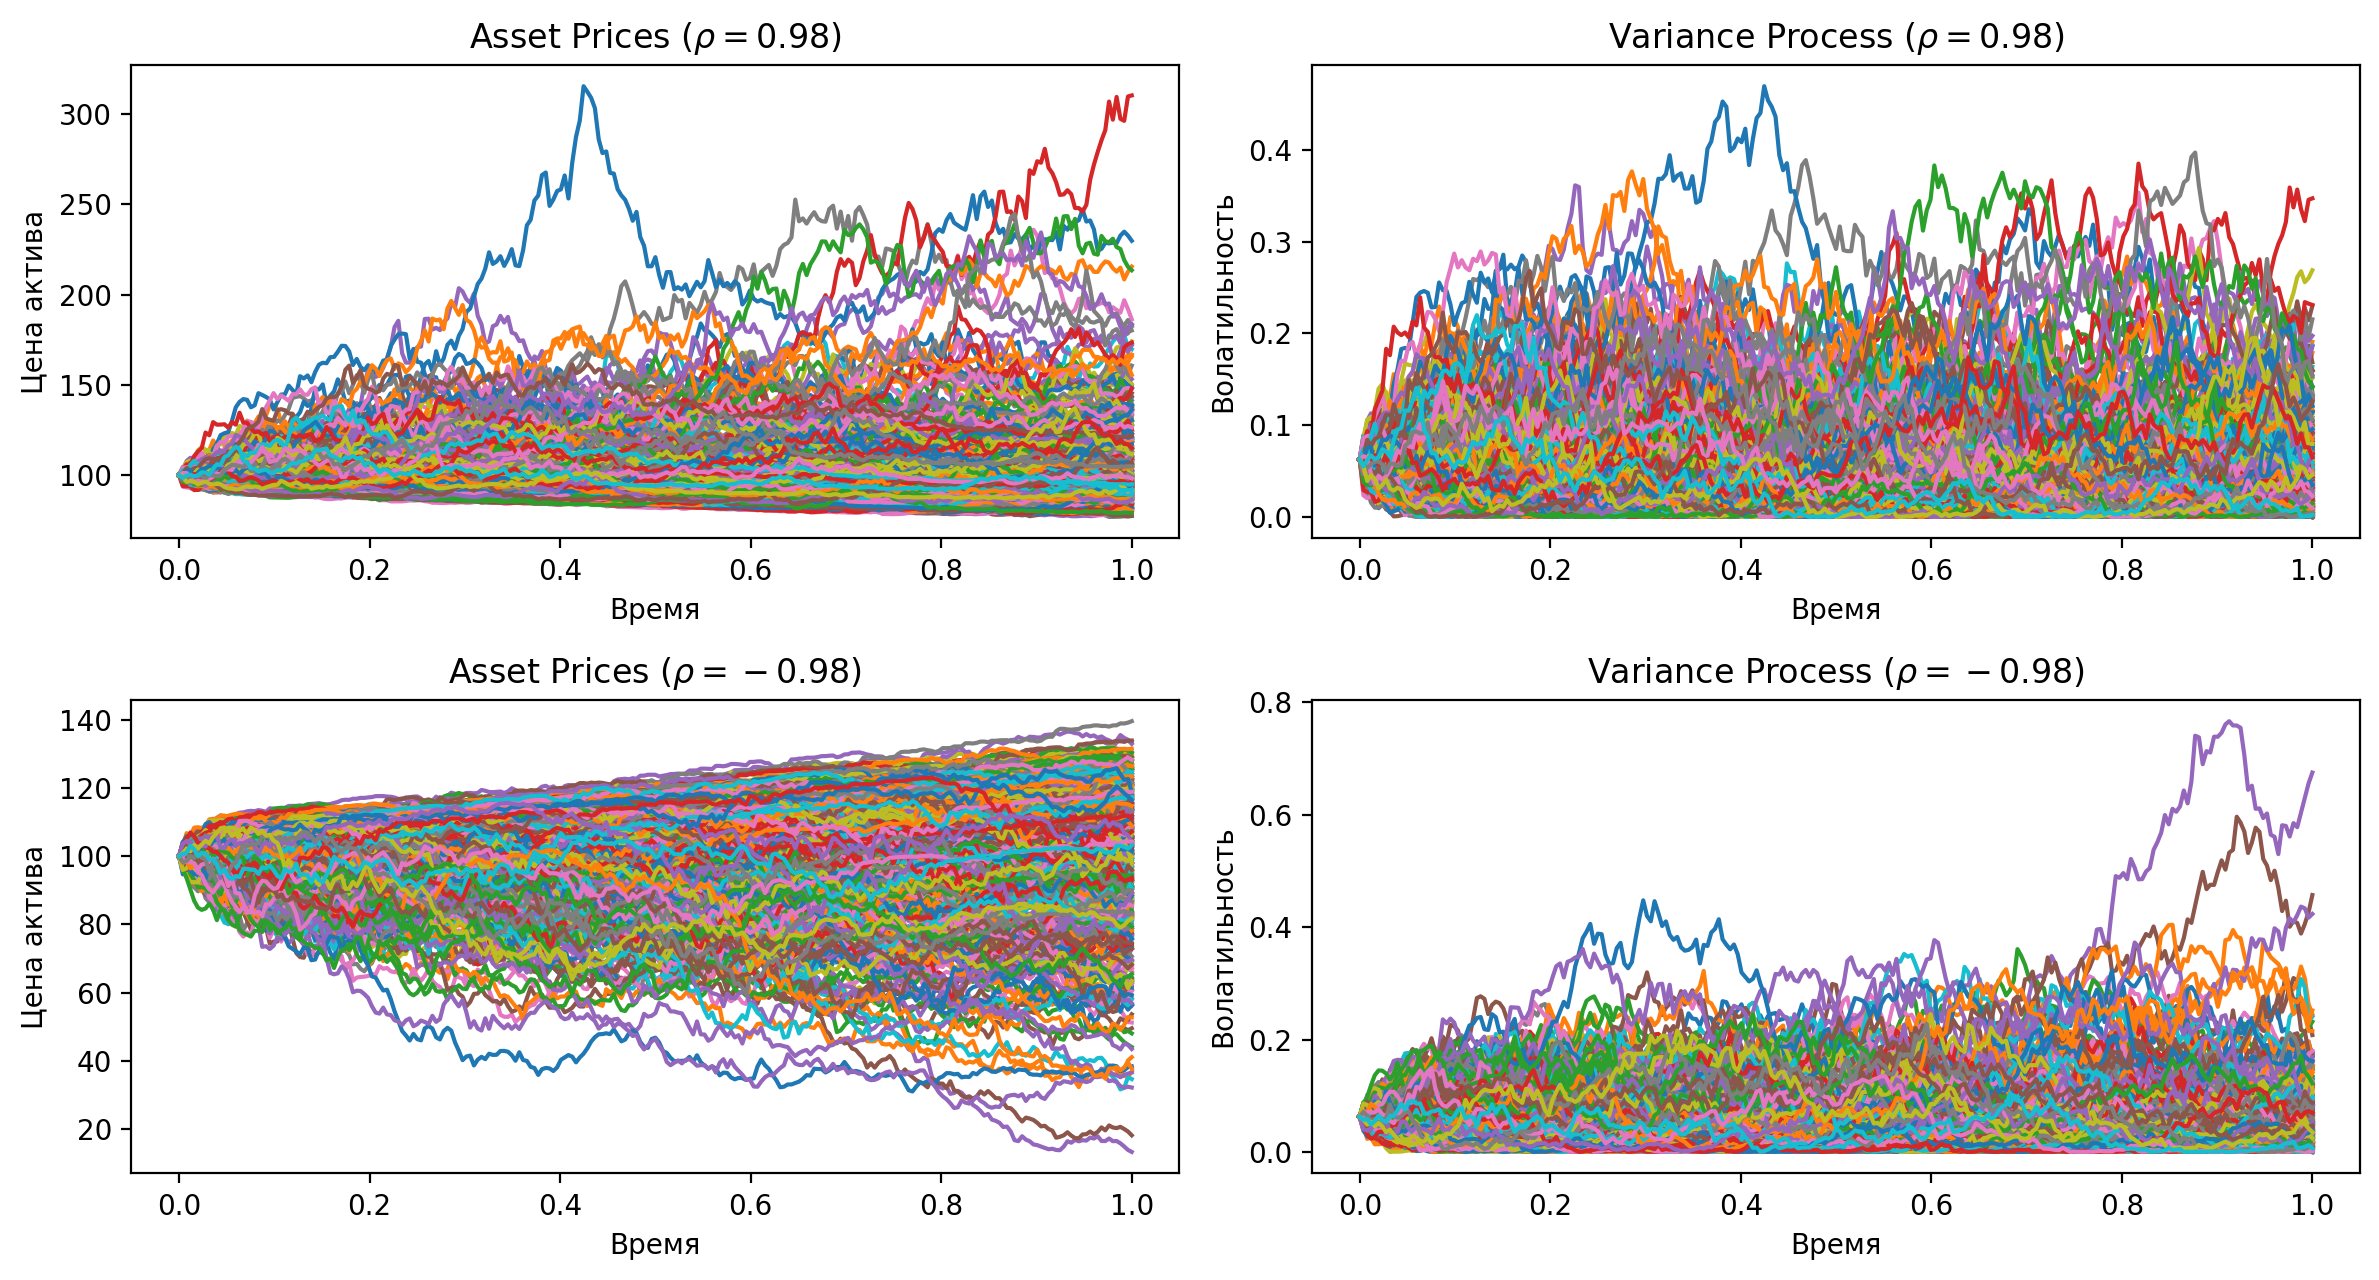

In [5]:
fig, ax  = plt.subplots(2, 2, figsize=(12,6.5), dpi=200)
time = np.linspace(0,T,N+1)

ax[0,0].plot(time,S_p)
ax[0,0].set_title(r'Asset Prices ($\rho = {}$)'.format(rho_p))
ax[0,0].set_xlabel('Время')
ax[0,0].set_ylabel('Цена актива')

ax[0,1].plot(time,v_p)
ax[0,1].set_title(r'Variance Process ($\rho = {}$)'.format(rho_p))
ax[0,1].set_xlabel('Время')
ax[0,1].set_ylabel('Волатильность')

ax[1,0].plot(time,S_n)
ax[1,0].set_title(r'Asset Prices ($\rho = {}$)'.format(rho_n))
ax[1,0].set_xlabel('Время')
ax[1,0].set_ylabel('Цена актива')

ax[1,1].plot(time,v_n)
ax[1,1].set_title(r'Variance Process ($\rho = {}$)'.format(rho_n))
ax[1,1].set_xlabel('Время')
ax[1,1].set_ylabel('Волатильность')

plt.tight_layout()
plt.show()

<hr>

### Сравнение распределений с geometrtic Brownian motion:

In [6]:
gbm = S0 * np.exp((r-theta**2/2)*T + np.sqrt(theta)*np.sqrt(T)*np.random.normal(0,1,M))

(20.0, 180.0)

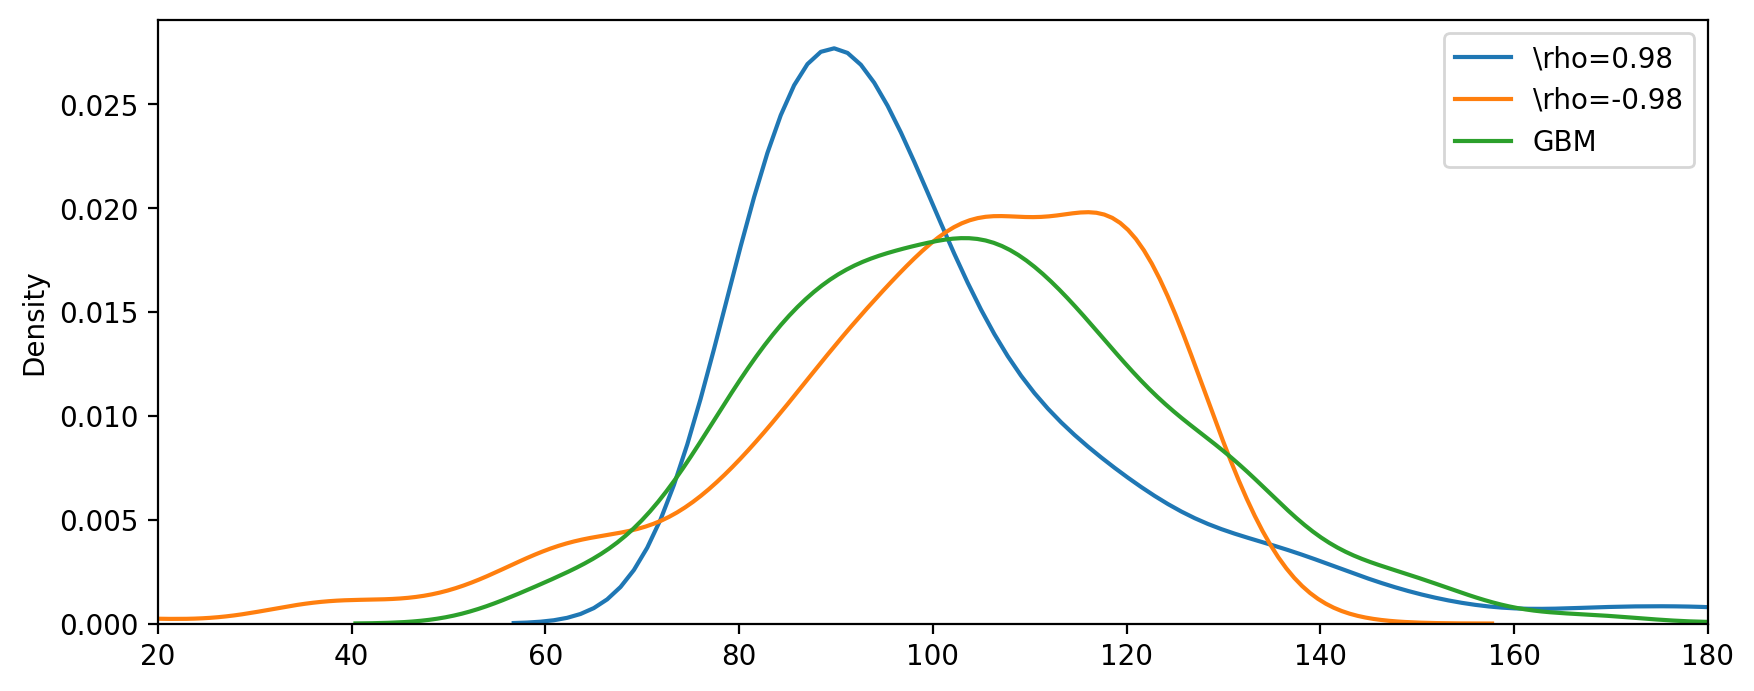

In [7]:
fig, ax = plt.subplots(figsize=(10,4), dpi=200)
ax = sns.kdeplot(S_p[-1], label=r'\rho=0.98', ax=ax)
ax = sns.kdeplot(S_n[-1], label=r'\rho=-0.98', ax=ax)
ax = sns.kdeplot(gbm, label='GBM', ax=ax)
ax.legend()
ax.set_xlim(20,180)

<hr>

### Volatility Smile:

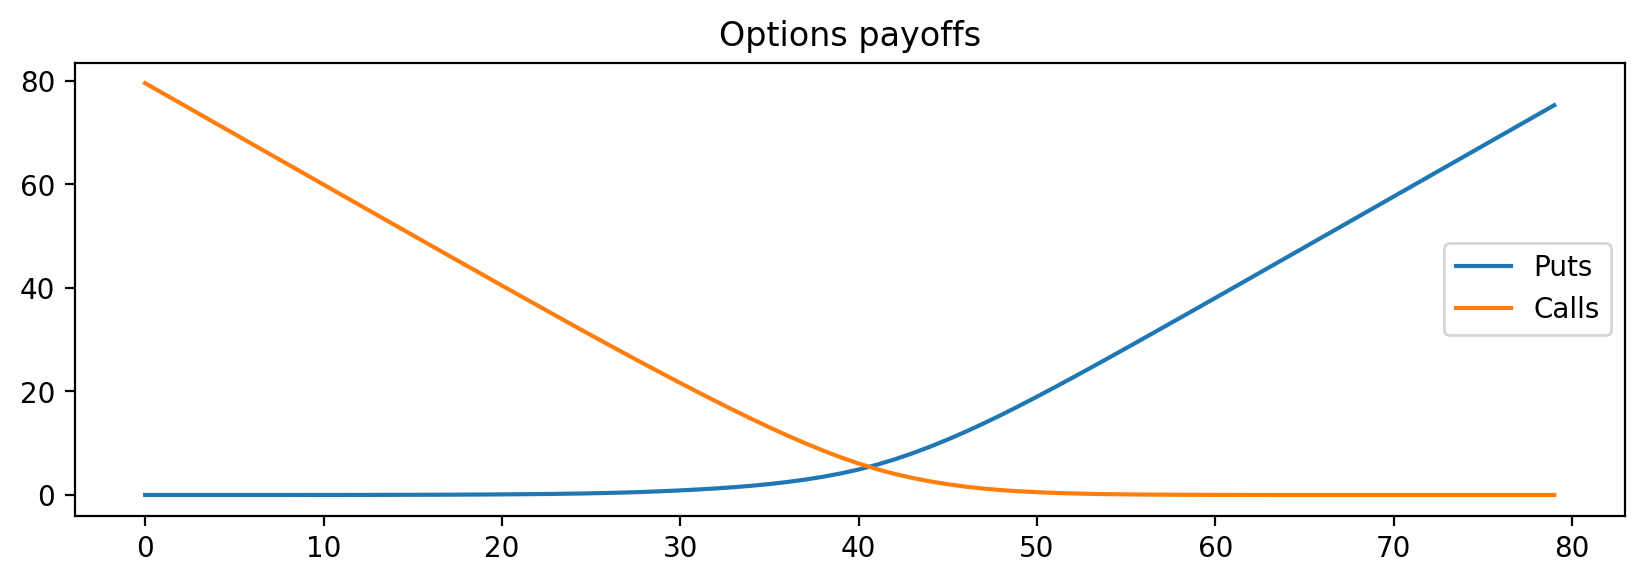

In [8]:
rho = -0.7
S, v = heston_model_sim(S0, v0, rho, kappa, theta, sigma, T, N, M)
K  = np.arange(20,180,2)

puts = np.array([np.exp(-r*T)*np.mean(np.maximum(k-S,0)) for k in K])
calls = np.array([np.exp(-r*T)*np.mean(np.maximum(S-k,0)) for k in K])

fig, ax = plt.subplots(figsize=(10,3), dpi=200)
ax.set_title('Options payoffs')
ax.plot(puts, label='Puts')
ax.plot(calls, label='Calls')
ax.legend()
plt.show()

In [9]:
put_ivs = implied_vol(puts, S0, K, T, r, flag='p', q=0, return_as='numpy', on_error='ignore')
call_ivs = implied_vol(calls, S0, K, T, r, flag='c', q=0, return_as='numpy')

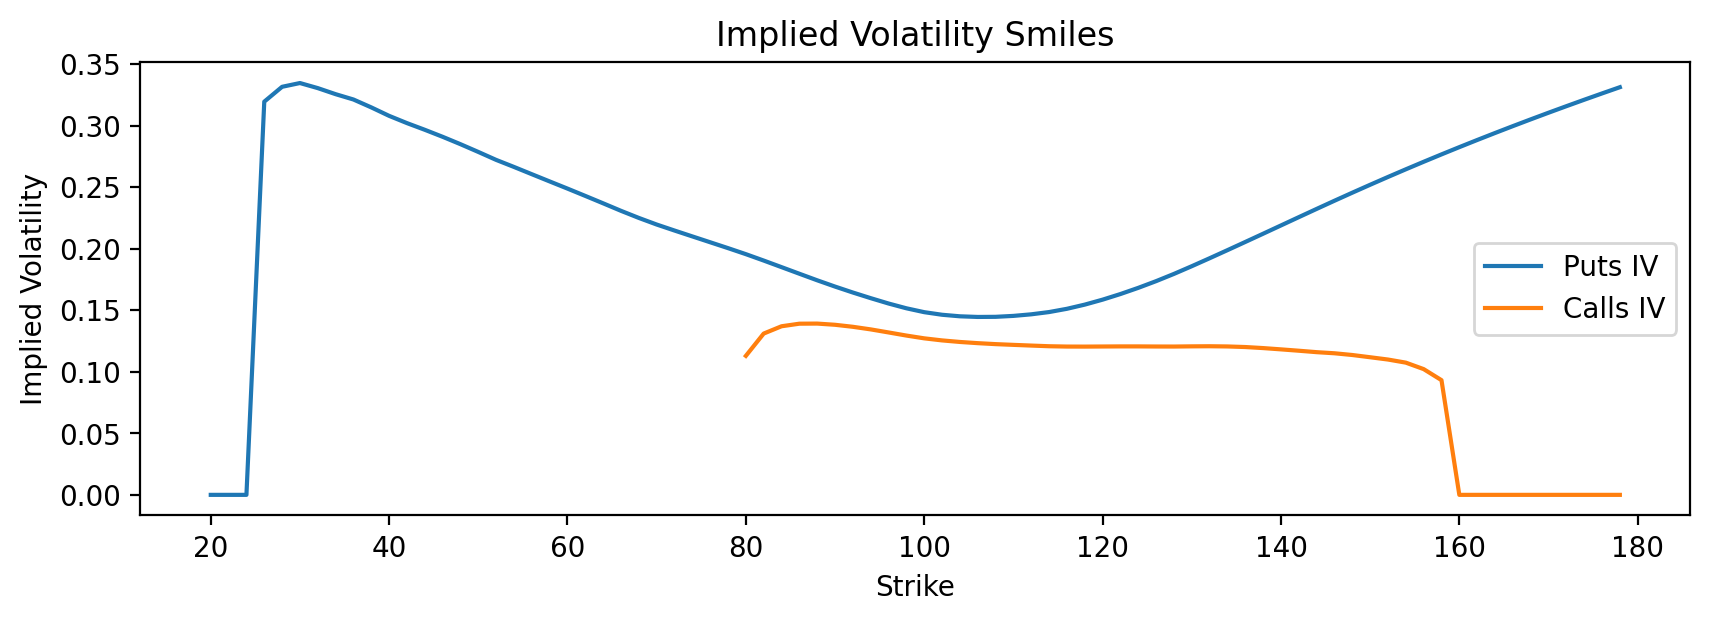

In [10]:
fig, ax = plt.subplots(figsize=(10,3), dpi=200)
ax.set_title('Implied Volatility Smiles')
ax.plot(K, put_ivs, label='Puts IV')
ax.plot(K, call_ivs, label='Calls IV')
ax.set_xlabel('Strike')
ax.set_ylabel('Implied Volatility')
ax.legend()
plt.show()